# This Looks Like That There
Pretrain CNN Only

In [1]:
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network as network
import experiment_settings
import data_functions
import common_functions

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
tensorflow version = 2.7.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'mjo_seed28'#'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
DOUBLE_CONV          = settings['double_conv']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs_pretrain']
LR_INIT              = settings['lr_pretrain']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch_pretrain']
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
    

[0 1 2 3 4 5 6 7 8]


ic| years_train: array([1952, 1963, 1900, 2006, 1961, 1914, 1930, 2005, 1953, 1935, 1981,
                        1940, 1909, 1997, 1913, 1971, 1980, 1918, 1948, 1921, 1949, 1950,
                        1936, 1973, 1975, 1906, 1933, 1986, 1985, 1942, 1959, 1982, 1939,
                        1929, 1999, 1955, 1989, 2001, 1954, 1920, 1974, 1972, 1990, 2003,
                        1946, 1911, 1919, 1976, 1998, 1956, 1966, 1962, 1941, 1995, 2009,
                        1931, 1993, 1927, 1938, 1916, 1984, 2008, 1979, 1947, 1925, 1902,
                        1910, 1983, 1917, 1991, 1965, 1958, 1957, 1977, 1967, 2007, 1944,
                        2000, 1996, 1904, 1926, 1915, 1928, 1968, 1970, 1937, 2002, 1934,
                        1960])
ic| years_val: array([1901, 1903, 1905, 1907, 1908, 1912, 1922, 1923, 1924, 1932, 1943,
                      1945, 1951, 1964, 1969, 1978, 1987, 1988, 1992, 1994, 2004, 2010])
ic| years_test: 2010


raw_data        = (40422, 17, 105, 3)
training data   = (32384, 17, 105, 3), (32384,)
validation data = (8038, 17, 105, 3), (8038,)
test data       = (365, 17, 105, 3), (365,)
X_mean          = 0.0010259029331182571
X_std           = 1.0290856233006693


In [9]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]

## Define the training callbacks and metrics

In [10]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['pretrain_patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
    es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

## Instantiate the model

In [11]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    cnn_only=True,    
    nlayers=NLAYERS,
    nfilters=NFILTERS,
    input_shape= X_train.shape[1:],
    output_shape=NCLASSES,
    prototypes_per_class=PROTOTYPES_PER_CLASS,
    network_seed=RANDOM_SEED,
    double_conv=DOUBLE_CONV,
    dense_nodes=settings['dense_nodes'],
    prototype_channels=settings['prototype_channels'],
    kernel_l1_coeff=settings['kernel_l1_coeff'],
    kernel_l2_coeff=settings['kernel_l2_coeff'],
    drop_rate=settings['drop_rate'],
    drop_rate_final=settings['drop_rate_final'],    
    coeff_cluster=0.0,#settings['coeff_cluster'],
    coeff_separation=0.0,#settings['coeff_separation'],
    coeff_l1=0.0,#settings['coeff_l1'],    
)
model.summary()

3
[16, 16, 16]
(17, 105, 3)
9
[10, 10, 10, 10, 10, 10, 10, 10, 10]
28
False
0.0
0.0
0.0
-0.5
True
32
64
0.0
0.0
0.4
0.2
False
Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 17, 105, 3)]      0         
                                                                 
 conv_0 (Conv2D)             (None, 17, 105, 16)       448       
                                                                 
 dropout (Dropout)           (None, 17, 105, 16)       0         
                                                                 
 maxpooling_0 (AveragePoolin  (None, 8, 52, 16)        0         
 g2D)                                                            
                                                                 
 conv_1 (Conv2D)             (None, 8, 52, 16)         2320      
                                                              

In [12]:
__ = ic(len(np.where(y_train==0)[0])/len(y_train))

ic| len(np.where(y_train==0)[0])/len(y_train): 0.14429965415019763


In [13]:
# compile the model
print('learning rate = ' + str(LR_INIT))

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=LR_INIT,
#         beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    ),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = metrics_list,
)

# train the model
tf.random.set_seed(RANDOM_SEED)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    batch_size=BATCH_SIZE,
    epochs=NEPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=callbacks_list
)


# save the model
model_filename = model_dir + 'pretrained_model_' + EXP_NAME
common_functions.save_model(model, model_filename)

learning rate = 0.00017548


2022-04-15 19:12:47.707872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
1012/1012 [==============================] - 14s 14ms/step - loss: 1.4840 - sparse_categorical_accuracy: 0.4437 - val_loss: 0.8259 - val_sparse_categorical_accuracy: 0.6743
Epoch 2/100
1012/1012 [==============================] - 14s 14ms/step - loss: 0.8937 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.7348
Epoch 3/100
1012/1012 [==============================] - 15s 15ms/step - loss: 0.7761 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.6001 - val_sparse_categorical_accuracy: 0.7610
Epoch 4/100
1012/1012 [==============================] - 15s 15ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.7132 - val_loss: 0.5587 - val_sparse_categorical_accuracy: 0.7784
Epoch 5/100
1012/1012 [==============================] - 16s 16ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.5244 - val_sparse_categorical_accuracy: 0.7920
Epoch 6/100
1012/1012 [==============================] - 15s 15ms/step - lo

2022-04-15 19:24:03.411169: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/mjo_seed28/pretrained_model_mjo_seed28/assets


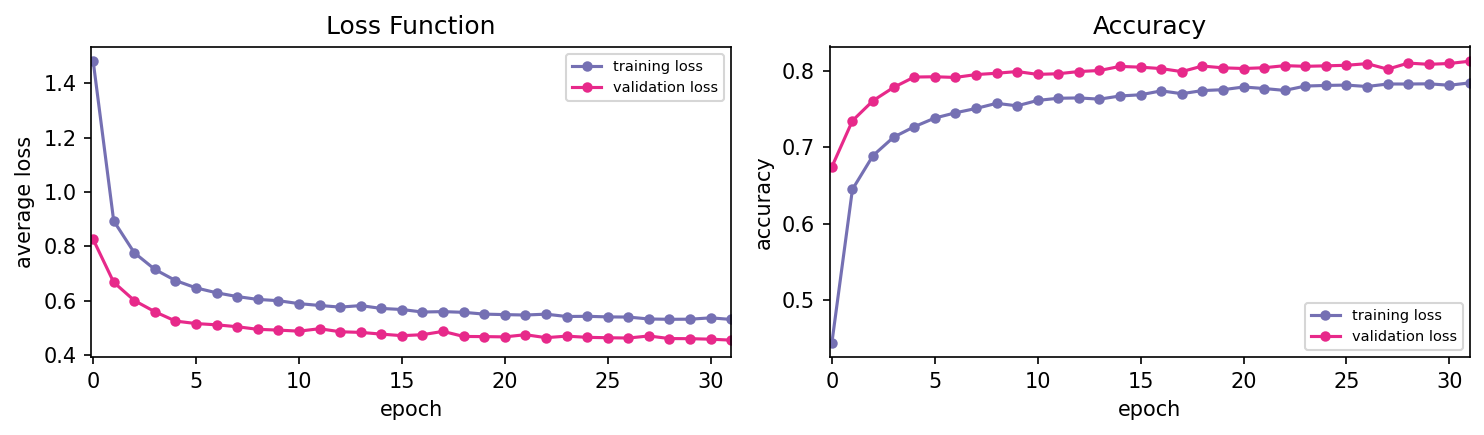

In [14]:
#-------------------------------
# Display the results
best_epoch = np.argmin(history.history['val_loss'])

#---- plot loss and errors ----
trainColor = (117/255., 112/255., 179/255., 1.)
valColor = (231/255., 41/255., 138/255., 1.)
FS = 7
MS = 4

plt.subplots(1,2,figsize=(10, 3))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'o-', color=trainColor, label='training loss', markersize=MS)
plt.plot(history.history['val_loss'], 'o-', color=valColor, label='validation loss', markersize=MS)
# plt.axvline(x=best_epoch, linestyle = '--', color='tab:gray')
plt.title("Loss Function")
plt.ylabel('average loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(frameon=True, fontsize=FS)
plt.xlim(-.1, 30+1)

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], 'o-', color=trainColor, label='training loss', markersize=MS)
plt.plot(history.history['val_sparse_categorical_accuracy'], 'o-', color=valColor, label='validation loss', markersize=MS)
# plt.axvline(x=best_epoch, linestyle = '--', color='tab:gray')
plt.title("Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(frameon=True, fontsize=FS)
plt.xlim(-.1, 30+1)

plt.tight_layout()
plt.savefig(model_diagnostics_dir + 'loss_history_pretrained_model_' + EXP_NAME + '.png', dpi=dpiFig)
plt.show()